In [1]:
import numpy as np
import pandas as pd
import ipyvolume as ipv

import matplotlib.pylab as plt
%matplotlib inline


from tyssue import config
from tyssue import Monolayer, Sheet
from tyssue import PlanarGeometry as geom
from tyssue.generation import extrude
from tyssue.dynamics import model_factory, effectors, units
from tyssue.solvers.quasistatic import QSSolver
from tyssue.dynamics.effectors import AbstractEffector
from tyssue.utils import to_nd

from tyssue.topology.base_topology import collapse_edge, remove_face
from tyssue.topology.sheet_topology import split_vert as sheet_split
from tyssue.topology.bulk_topology import split_vert as bulk_split

from tyssue.draw import sheet_view, highlight_cells

from tyssue.core.sheet import get_opposite

from tyssue.generation import single_cell
from tyssue.core.objects import _is_closed_cell
from tyssue.topology import condition_4i, condition_4ii

#from tyssue.topology import connectivity

In [2]:
class LineTension(AbstractEffector):

    dimensions = units.line_tension
    magnitude = "line_tension"
    label = "Line tension"
    element = "edge"
    specs = {"edge": {"is_active": 1, "line_tension": 1.0, "myosin":1.0}}

    spatial_ref = "mean_length", units.length

    @staticmethod
    def energy(eptm):
        return eptm.edge_df.eval(
            "line_tension" "* myosin" "/ (length)"
        )  # accounts for half edges

    @staticmethod
    def gradient(eptm):
        grad_srce = -eptm.edge_df[eptm.ucoords] * to_nd(
            eptm.edge_df.eval("line_tension"), len(eptm.coords)
        )
        grad_srce.columns = ["g" + u for u in eptm.coords]
        grad_trgt = -grad_srce
        return grad_srce, grad_trgt

In [3]:
sheet = Sheet.planar_sheet_2d('flat', 30, 30, 1, 1, noise=0.2)
to_cut = sheet.cut_out([(0.1, 6), (0.1, 6)])
sheet.remove(to_cut, trim_borders=True)
sheet.sanitize(trim_borders=True)
geom.center(sheet)
geom.update_all(sheet)
model = model_factory(
    [
        LineTension,
        effectors.FaceContractility,
        effectors.FaceAreaElasticity
    ]
)

specs = {
    "face": {
        "contractility": 5e-2,
        "prefered_area": sheet.face_df.area.mean(),
        "area_elasticity": 1.
    },
    "edge": {
        "line_tension": 1e-2,
        "is_active": 1
    },
    "vert": {
        "is_active": 1
    },
}

sheet.update_specs(specs, reset=True)

Reseting column is_active of the vert dataset with new specs


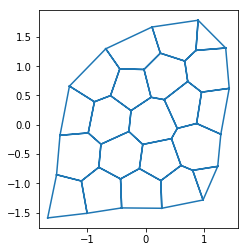

In [4]:
solver = QSSolver()

pola_specs = {
    "face" : {
         "myosin" : 10.,
    },
    "edge" : {
         "myosin" : 1., 
         "desorption_rate" : 10., # to be updated with tension
         "absorption_rate" : 1.,
    },
}
sheet.update_specs(pola_specs, reset=True)


res = solver.find_energy_min(sheet, geom, model)

fig, ax = sheet_view(sheet, mode="quick")


Let $n_{ij}$ be the number of myosin molecules at edge $ij$, $n_\alpha$ the total number of myosin in cell $\alpha$, and $n_{c\alpha}$ the cytoplasmic concentration of myosin. We have the following differential equation:

$$
\frac{dn_{ij}}{dt} = -k_d^0(1 - \exp(-t_{ij}/t_c))n_{ij} + k_a n_{c\alpha}
$$

With 
$$
n_{c\alpha} = n_\alpha - \sum_{kl \in \alpha}n_{kl}
$$
 
This system of coupled ordinary differential equations can be written in the form:
$$
\dot{\mathbf{n}} = A \mathbf{n} + B
$$

Where $\mathbf{n}$ is a vector containing the $N_e$ $n_{ij}$, one per edge, $A$ a $N_e\times N_e$ matrix and B a $N_e$ vector.


For connected components, we have:
$$
B_{ij} = k_a n_\alpha
$$

$$
A_{ij, ij} = -k_d^0(1 - \exp(-t_{ij}/t_c) - k_a
$$

$$
A_{ij, kl} = - k_a
$$

So most of the work that needs to be donne is finding which terms of A are non-zero...
Then we have:
$$
\begin{eqnarray}
\dot{\mathbf{n}} &=& A \mathbf{n} + B\\
A^{-1}(\dot{\mathbf{n}} - B) &=& \mathbf{n}\\
\end{eqnarray}
$$

And we can solve this system of equations to get $\dot{\mathbf{n}}$.

### Connectivity matrix

This should go in `tyssue.utils.connectivity`

In [5]:
from scipy import sparse

def index_mesh(df):
    ii1, ii2 = np.meshgrid(df.index, df.index)
    return pd.DataFrame({"row": ii1.ravel(), "col": ii2.ravel()})

    

def edge_in_face_connectivity(eptm):
    
    mesh = eptm.edge_df.groupby("face").apply(index_mesh)
    ef_connect = sparse.coo_matrix(
             (np.ones(mesh.shape[0]), (mesh["row"], mesh["col"])),
        shape=(eptm.Ne, eptm.Ne),
        dtype=int,
    ).toarray()
    return ef_connect
    

In [6]:
def test_ef_connect(sheet):
    ef_connect = edge_in_face_connectivity(sheet)

    idx = sheet.edge_df.query(f"face == {sheet.Nf-1}").index
    assert ef_connect[idx[0], idx[1]]

In [7]:
pola_specs = {
    "face" : {
         "myosin" : 10.,
    },
    "edge" : {
         "myosin" : 1., 
         "desorption_rate" : 10., # to be updated with tension
         "absorption_rate" : 1.,
    },
}
sheet.update_specs(pola_specs, reset=True)


Reseting column myosin of the face dataset with new specs
Reseting column myosin of the edge dataset with new specs
Reseting column desorption_rate of the edge dataset with new specs
Reseting column absorption_rate of the edge dataset with new specs


In [8]:
def get_matrix(sheet):
    ef_connect = edge_in_face_connectivity(sheet)
    mat = (- np.diag(sheet.edge_df["desorption_rate"])
           - ef_connect * sheet.edge_df['absorption_rate'].values[:, None])
    
    return mat
    
    

In [9]:
def ode_func(sheet):
    A = get_matrix(sheet)
    B = sheet.upcast_face("myosin").values
    invA = np.linalg.inv(A)
    dot_n = np.linalg.solve(invA, sheet.edge_df['myosin']) + B 
    return dot_n

In [10]:
from tyssue.solvers.viscous import EulerSolver
class EulerProtSolver(EulerSolver):
    
    
    def ode_func_prot(self):
        A = get_matrix(self.eptm)
        B = self.eptm.upcast_face("myosin").values
        invA = np.linalg.inv(A)
        dot_n = np.linalg.solve(invA, self.eptm.edge_df['myosin']) + B 

        return dot_n
    

    def solve(self, tf, dt, on_topo_change=None, topo_change_args=()):
        for t in np.arange(self.prev_t, tf + dt, dt):
            EulerSolver.solve(self, dt, dt)
            dot_n=self.ode_func_prot()
            self.eptm.edge_df.myosin = self.eptm.edge_df.myosin + dot_n * dt
            
    

In [11]:
from tyssue.behaviors.event_manager import EventManager
from tyssue.core.history import History 
# Initiate manager
manager = EventManager('face')
#manager.append(basic_events.reconnect)

#Initiate history to save all columns in all df
history = History(sheet, extra_cols={"face": sheet.face_df.columns,
                                      "edge": list(sheet.edge_df.columns),
                                      "vert": list(sheet.vert_df.columns)
                                     })

# Starting viscous solver
solver = EulerProtSolver(
    sheet,
    geom, 
    model,
    history = history,
    manager = manager,
    bounds = (-sheet.edge_df.length.median()/10,
        sheet.edge_df.length.median()/10)
    )

In [18]:
from tyssue.behaviors.sheet import basic_events
#sheet=save_sheet.copy()
spec={'face_id':16,
      'contractile_increase':1.5,
     'multiple':True}
manager.append(basic_events.contraction, **spec)
manager.update()
sheet.vert_df['viscosity'] = 0.1

sheet.face_df['id'] = sheet.face_df.index

# Solving part... 
dt = 0.1
sheet.settings["dt"] = dt
solver.solve(5-dt, dt)

In [19]:
sheet_final = solver.history.retrieve(5)

In [20]:
sheet_final.edge_df.myosin

edge
0      0.625000
1      0.714286
2      0.625000
3      0.714286
4      0.666667
5      0.714286
6      0.666667
7      0.714286
8      0.714286
9      0.625000
10     0.625000
11     0.714286
12     0.625000
13     0.666667
14     0.625000
15     0.625000
16     0.625000
17     0.625000
18     0.666667
19     0.666667
20     0.666667
21     0.666667
22     0.666667
23     0.625000
24     0.666667
25     0.666667
26     0.666667
27     0.666667
28     0.625000
29     0.666667
         ...   
77     0.588235
78     0.588235
79     0.588235
80     0.666667
81     0.625000
82     0.714286
83     0.666667
84     0.588235
85     0.666667
86     0.588235
87     0.769231
88     0.714286
89     0.588235
90     0.588235
91     0.625000
92     0.714286
93     0.769231
94     0.625000
95     0.625000
96     0.666667
97     0.666667
98     0.769231
99     0.714286
100    0.666667
101    0.666667
102    0.666667
103    0.769231
104    0.714286
105    0.714286
106    0.666667
Name: myosin, Lengt

In [21]:
sheet_final.edge_df.line_tension.unique()

array([0.01])

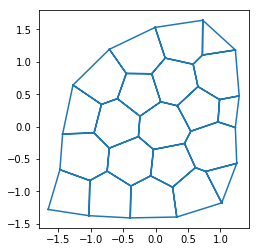

In [22]:
fig, ax = sheet_view(sheet_final, mode="quick")

In [23]:
sheet.edge_df[sheet.edge_df.face==16]

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,...,fy,ux,uy,is_valid,sub_area,line_tension,is_active,myosin,desorption_rate,absorption_rate
edge,,,,,,,,,,,,,,,,,,,,,
82,7,0.049338,0.345326,16,27,-0.024503,-0.344456,0.988321,0.416292,0.963818,...,0.236707,-0.075540,-0.997143,True,0.024669,0.01,1,0.714286,10.0,1.0
88,13,0.057584,0.281504,16,7,0.267844,-0.086628,0.963818,0.071837,1.231662,...,0.236707,0.961442,-0.275009,True,0.028792,0.01,1,0.714286,10.0,1.0
92,27,0.061878,0.308358,16,16,-0.303006,-0.057199,1.291327,0.473491,0.988321,...,0.236707,-0.987248,-0.159192,True,0.030939,0.01,1,0.714286,10.0,1.0
105,16,0.070123,0.491915,16,13,0.059665,0.488283,1.231662,-0.014792,1.291327,...,0.236707,0.122690,0.992445,True,0.035062,0.01,1,0.714286,10.0,1.0
